In [1]:
from importlib import reload
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from byc import standard_analysis as sa
from byc import database, plotting, files, utilities

plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = 'Arial'

Read in the data by selecting the master_index .csv for the experiment being analyzed. For this tutorial located at `...\byc_data\example_byc_expts\20200221_byc_analysis\20200221_byc_master_index.csv`

In [5]:
traces, filenames = sa.set_processed_traces(3, 10)

value is  0
cells_dfs is now 1 elements long
Checking senescence data for cell 0
sen_value is False
first_frame is 1
last_frame is 1
sen_distance_from_start is -1
Processing trace dataframe for cell 0 of 0


Have a look at the trace database to get a sense of what entries should look like

In [2]:
from byc import database
tracedb = database.byc_database
tracedb.trace_database_df.head()

,expt_name,trace_path,chase_index,bud_roi_path,trace_relpath,date
0,20191106_byc_by4741_young_NS,C:\Users\John Cooper\Projects\byc\data\2019110...,5,NaN,20191106_byc\analysis\20191106_byc_by4741_youn...,20191106
1,20191106_byc_by4741_young_NS,C:\Users\John Cooper\Projects\byc\data\2019110...,5,NaN,20191106_byc\analysis\20191106_byc_by4741_youn...,20191106
2,20191106_byc_by4741_young_NS,C:\Users\John Cooper\Projects\byc\data\2019110...,5,NaN,20191106_byc\analysis\20191106_byc_by4741_youn...,20191106
3,20191106_byc_by4741_young_NS,C:\Users\John Cooper\Projects\byc\data\2019110...,5,NaN,20191106_byc\analysis\20191106_byc_by4741_youn...,20191106
4,20191106_byc_by4741_young_NS,C:\Users\John Cooper\Projects\byc\data\2019110...,5,NaN,20191106_byc\analysis\20191106_byc_by4741_youn...,20191106


Create an experiment name to use when adding this experiment to the byc trace database

In [17]:
expt_name = "20200221_byc_JC069_rpn4d"

Add this experiment to trace database

In [9]:
tracedb.add_expt_to_trace_database(filenames, expt_name, chase_index=np.NaN, date='20200221')

Have a look at what you just added

In [18]:
tracedb.trace_database_df.set_index('expt_name').loc[expt_name, :]

trace_path      C:\Users\John Cooper\Box Sync\Finkelstein-Mato...
chase_index                                                   NaN
bud_roi_path                                                  NaN
Name: 20200221_byc_JC069_rpn4d, dtype: object

Read experiment trace dataframes in using database

In [19]:
cell_dfs = tracedb.get_cell_trace_dfs(expt_name)

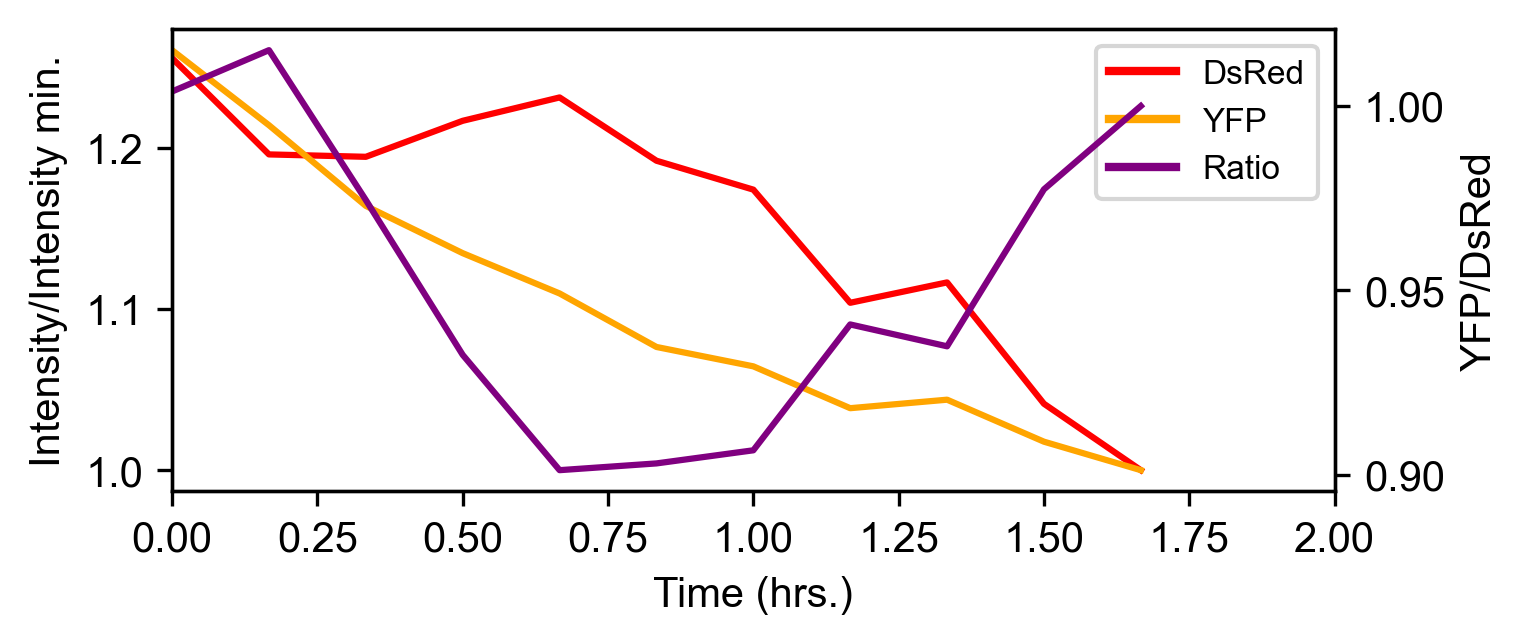

In [22]:
fig = plt.figure(figsize=(5, 2))
fig.set_dpi(300)

df = cell_dfs[0]
ax = plt.axes()

yfp_norm = df.yfp_mean/df.yfp_mean.min()
dsred_norm = df.dsred_mean/df.dsred_mean.min()

ax.set_ylabel("Intensity/Intensity min.")
ax.set_xlabel("Time (hrs.)")

ax.set_xlim(0, 2)
#ax.set_ylim(1, 1.8)

ax.plot(df.hours, dsred_norm, color='red')
ax.plot(df.hours, yfp_norm, color='orange')

ax2 = ax.twinx()
ax2.set_ylabel("YFP/DsRed")

ax2.plot(df.hours, yfp_norm/dsred_norm, color='purple')

custom_lines = [Line2D([0], [0], color='red', lw=2),
                Line2D([0], [0], color='orange', lw=2),
                Line2D([0], [0], color='purple', lw=2)]

ax.legend(custom_lines, ['DsRed',
                         'YFP',
                         'Ratio'], fontsize=8)

plt.show()

### 20201127_byc

In [261]:
import os
from importlib import reload
import re

import numpy as np
import pandas as pd
from skimage.draw import line
from skimage import io
import matplotlib.pyplot as plt
import matplotlib
plt.style.use('default')
matplotlib.rcParams['font.sans-serif'] = 'Arial'

from read_roi import read_roi_zip

from byc import files, utilities, constants
from byc.imagejpc import addcellroi
import byc.standard_analysis as sa



In [6]:
# Create a master index data frame for the purpose
# of running byc/bin/run_segmentation to crop and
# Otsu threshold based on crop ROIs
write = True
compartment_dir = r"C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg"
exptdir = os.path.dirname(compartment_dir)
pattern = constants.patterns.crop_roi_df_file
paths = utilities.get_filepaths_with_pattern(pattern,
                                             rootdir=exptdir)

dfs = [pd.read_csv(p) for p in paths]
mdf = pd.concat(dfs, ignore_index=True)
exptdir = os.path.dirname(mdf.compartment_dir.unique()[0])
mdf_path = utilities.get_all_master_index_paths(exptdir)[0]

if os.path.exists(mdf_path):
    old_mdf = pd.read_csv(mdf_path)
    new_mdf = pd.concat([old_mdf, mdf])
else:
    print(f'No file at {mdf_path}/nCreating new master index there')
    
if write:
    # Save the updated master_index
    mdf.to_csv(mdf_path, index=False)

In [2]:
mdf = pd.read_csv(files.select_file('prompt'))
mdf.channels_collected = 'bf yfp rfp'

In [272]:
for mod in [files, addcellroi, constants, utilities, sa]:
    reload(mod)

In [270]:
bycds.cell_trace_dfs

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [274]:
bycds = sa.bycDataSet(manual_select=True)
dfs = bycds.cell_trace_dfs

Found data for cell 0 at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg\20201127_byc_xy00_cell000_rfp_stack.csv
Found data for cell 0 at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg\20201127_byc_xy00_cell000_yfp_stack.csv
Found data for cell 1 at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg\20201127_byc_xy00_cell001_rfp_stack.csv
Found data for cell 1 at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg\20201127_byc_xy00_cell001_yfp_stack.csv
Found data for cell 2 at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg\20201127_byc_xy00_cell002_rfp_stack.csv
Found data for cell 2 at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg\20201127_byc_xy00_cell002_yfp_stack.csv
Found data for cell 3 at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg\20201127_byc_xy00_cell003_rfp_stack.csv
Found 

In [275]:
df = pd.concat(dfs, ignore_index=True)
df = df.sort_values(by='total_hours')

In [181]:
def make_cell_trace_df(master_index_df, index, collection_interval=10):
    """
    Find all .csv fluorescent trace measurement files
    for the cell at index <index> in the master_index_df,
    add labels found in the master index for that cell,
    and return the completed dataframe
    """
    mdf = master_index_df
    cellrow = mdf.loc[index, :]
    base_filename = f'{cellrow.date}_byc_xy{str(cellrow.xy).zfill(2)}_cell{str(cellrow.cell_index).zfill(3)}'
    pattern = f'({base_filename})_(.+)_(stack.csv)'
    for dirpath, dirnames, filenames in os.walk(cellrow.compartment_dir):   
        measurement_dfs = []
        matches = []
        for filename in filenames:
            match = re.search(pattern, filename)
            if match:
                # Define path to file and read in as dataframe
                filepath = os.path.join(dirpath, filename)
                print(f'Found data for cell {index} at {filepath}')
                df = pd.read_csv(filepath)
                # Set time data. Absolute hours is hours
                # since the experiment started. Hours is
                # hours since beginning of data collection
                #
                # Note that I don't add these columns to the 
                # df until I'm down finding new channel .csvs
                # because I don't want the time columns to get
                # labelled with '_<channel_name>'
                hours = ((df.Slice-1)*collection_interval)/60
                rois = read_roi_zip(cellrow.crop_roi_set_path)
                first_position = rois[list(rois.keys())[0]]['position']
                first_position_ind = first_position - 1
                abs_hours = ((df.Slice-1+first_position_ind)*collection_interval)/60
                # Add hours to death column if end event for crop
                # ROIs was 'death'. Otherwise set column to np.nan
                last_position = rois[list(rois.keys())[-1]]['position']
                last_position_ind = last_position - 1
                if cellrow.end_event_type == 'death':
                    hours_to_death = hours[hours.index[-1]] - hours
                else:
                    hours_to_death = np.full(len(hours), np.nan)
                matches.append(match)
                # Name the measurement data with the fluorescent channel.
                # Add identifying information from master index
                channel = match.group(2)
                newcols = [f'{col}_{channel}' for col in df.columns]
                df.columns = newcols
                measurement_dfs.append(df)

    if len(measurement_dfs) == 1:
        # Only one channel df found
        cell_df = measurement_dfs[0]        
    elif len(measurement_dfs) > 1:
        # Multiple channels, need to combine
        for df in measurement_dfs[1:]:
            cell_df = measurement_dfs[0].join(df)
    else:
        # No data found
        print(f'No data found for cell with pattern: {pattern}')
        print(f'Checked compartment dir: {cellrow.compartment_dir}')
        return None
    
    # Add annotation information to the cell trace df
    for col in mdf.columns:
        cell_df[col] = cellrow[col]
    # Add time information defined above
    cell_df.loc[:, 'hours'] = hours
    cell_df.loc[:, 'abs_hours'] = abs_hours
    cell_df.loc[:, 'hours_to_death'] = hours_to_death
    cell_df.loc[:, 'total_hours'] = (len(hours)*collection_interval)/60
        
    return cell_df

def make_cell_trace_dfs(master_index_df):
    """
    Use make_cell_df() to look up and aggregate
    fluorescent channel trace data for each cell
    recorded in the provied master index
    
    Return a list of these dataframes
    """
    mdf = master_index_df
    cell_dfs = []
    for i in mdf.index:
        cellrow = mdf.loc[i, :]
        if len(cellrow.shape) > 1:
            print(f'Multiple entries for cell at row {i}')
            pass
        else:
            cell_df = make_cell_trace_df(mdf, i)
            cell_dfs.append(cell_df)
    
    return cell_dfs

In [209]:
dfs = make_cell_trace_dfs(mdf)

Found data for cell 0 at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg\20201127_byc_xy00_cell000_rfp_stack.csv
Found data for cell 0 at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg\20201127_byc_xy00_cell000_yfp_stack.csv
Found data for cell 1 at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg\20201127_byc_xy00_cell001_rfp_stack.csv
Found data for cell 1 at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg\20201127_byc_xy00_cell001_yfp_stack.csv
Found data for cell 2 at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg\20201127_byc_xy00_cell002_rfp_stack.csv
Found data for cell 2 at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg\20201127_byc_xy00_cell002_yfp_stack.csv
Found data for cell 3 at C:\Users\John Cooper\Projects\byc\data\20201127_byc\pJC189_mScarletI-1013deg\20201127_byc_xy00_cell003_rfp_stack.csv
Found 

856.537
698.3050000000001
852.214
679.5520000000001
913.8529999999998
872.1859999999999


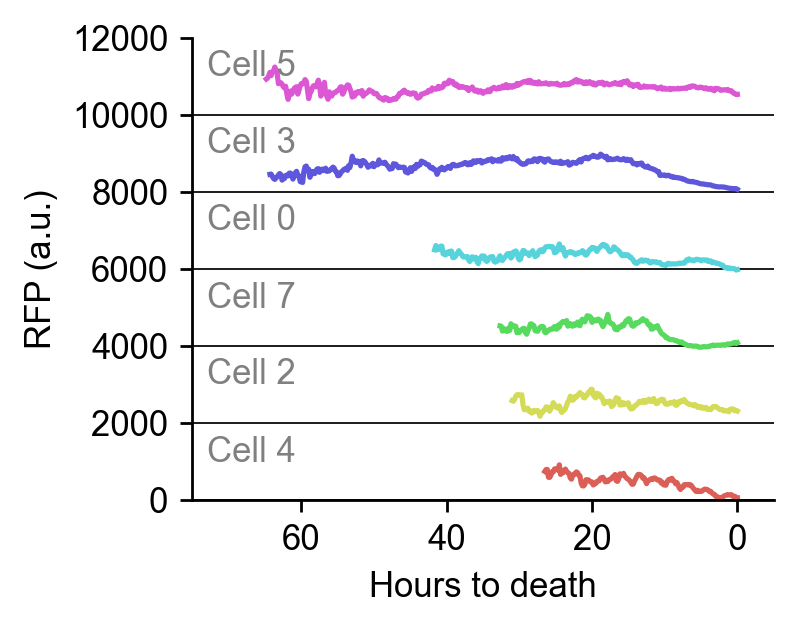

In [276]:
subdf = df.loc[df.plasmid == 'pJC197']
subdf = subdf[subdf.end_event_type=='death']
dfs = [subdf.loc[subdf.cell_index==i, :].sort_values(by='hours') for i in subdf.cell_index.unique()]
mins = np.array([celldf.loc[:, y_var].min() for celldf in dfs])
bg = np.median(mins)
bg = 900
offset_step = 2000
y_ul = offset_step*len(dfs)
fig = plt.figure(figsize=(3, 0.4*len(dfs)))
fig.set_dpi(250)
colors = sns.color_palette("hls", len(dfs))
ax = plt.axes()
ax.set_xlim(75, -5)
ax.set_ylim(0, y_ul)
ax.set_yticks(np.arange(0, y_ul+1, offset_step))
ax.set_ylabel('RFP (a.u.)')
ax.set_xlabel('Hours to death')

y_var = 'Mean_rfp'
for i, celldf in enumerate(dfs):
    print(celldf[y_var].max() - celldf[y_var].min())
    
    offset = offset_step*i
    cell_index = celldf.cell_index.iloc[0]
    ax.text(73, offset + 0.5*offset_step, f'Cell {cell_index}',
            fontsize=10, color='gray')
    ax.axhline(offset, linewidth=0.5, color='black')
    if np.nan in celldf.hours_to_death.values:
        print(f"No hours to death for cell {i}")
    ax.plot(celldf.hours_to_death, celldf[y_var] + offset - bg,
            color=colors[i], linewidth=1.5)
        
names = ['top', 'right']

for spine in [ax.spines[n] for n in names]:
    spine.set_visible(False)

2069.4169999999995
384.0129999999999
2179.702
2685.3730000000005
2334.029
2387.595
2195.561
2359.937


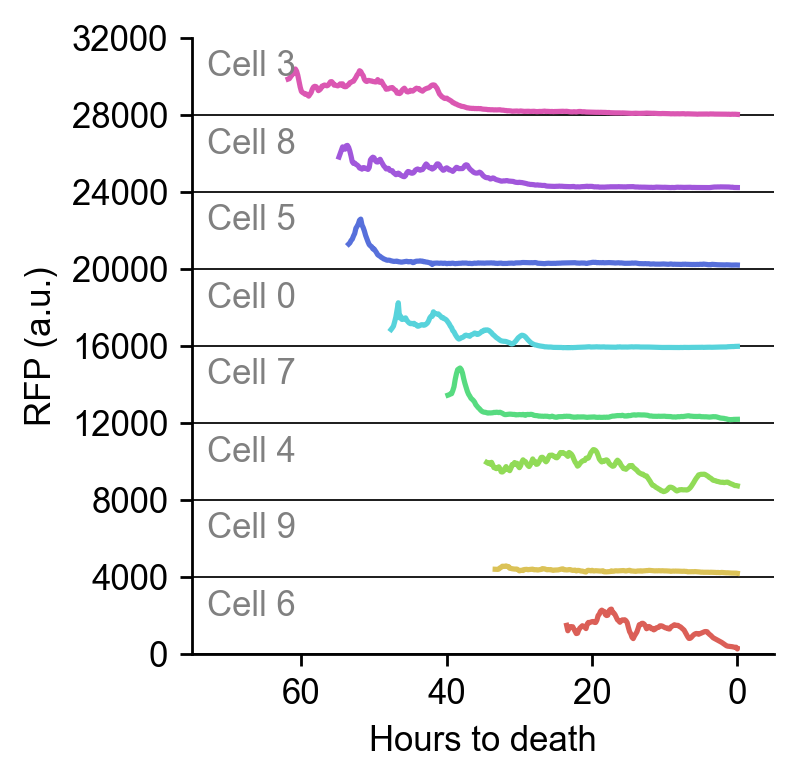

In [277]:
subdf = df.loc[df.plasmid == 'pJC189']
subdf = subdf[subdf.end_event_type=='death']
dfs = [subdf.loc[subdf.cell_index==i, :].sort_values(by='hours') for i in subdf.cell_index.unique()]
mins = np.array([celldf.loc[:, y_var].min() for celldf in dfs])
bg = np.median(mins)
bg = 900
offset_step = 4000
y_ul = offset_step*len(dfs)
fig = plt.figure(figsize=(3, 0.4*len(dfs)))
fig.set_dpi(250)
colors = sns.color_palette("hls", len(dfs))
ax = plt.axes()
ax.set_xlim(75, -5)
ax.set_ylim(0, y_ul)
ax.set_yticks(np.arange(0, y_ul+1, offset_step))
ax.set_ylabel('RFP (a.u.)')
ax.set_xlabel('Hours to death')

y_var = 'Mean_rfp'
for i, celldf in enumerate(dfs):
    print(celldf[y_var].max() - celldf[y_var].min())
    
    offset = offset_step*i
    cell_index = celldf.cell_index.iloc[0]
    ax.text(73, offset + 0.5*offset_step, f'Cell {cell_index}',
            fontsize=10, color='gray')
    ax.axhline(offset, linewidth=0.5, color='black')
    if np.nan in celldf.hours_to_death.values:
        print(f"No hours to death for cell {i}")
    ax.plot(celldf.hours_to_death, celldf[y_var] + offset - bg,
            color=colors[i], linewidth=1.5)
        
names = ['top', 'right']

for spine in [ax.spines[n] for n in names]:
    spine.set_visible(False)

(80.0, -10.0)

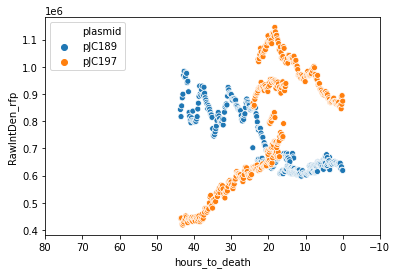

In [124]:
import seaborn as sns
table = df.pivot_table(index=['plasmid', 'Slice_rfp'], aggfunc='mean').reset_index()
ax = sns.scatterplot(data=table, x='hours_to_death', y='RawIntDen_rfp', hue='plasmid')
ax.set_xlim(80, -10)

In [211]:
for celldf in dfs:
    print(celldf.loc[:, y_var].min())

802.0189999999999
1022.688
916.819
921.283
1326.838
1093.868
1152.421
1061.052
1114.752
1080.03
866.8
1124.985
1072.111
964.53
951.44
1268.097
1104.563
861.878
